# IBPA Bond Data Scraper & Analyzer üìä

## Overview
This notebook scrapes Indonesian bond data from PHEI (Pusat Harga Efek Indonesia) website, processes yield curves, calculates spot rates and forward rates, and generates professional visualizations.

## Features
- üîç **Data Scraping**: Automated extraction of bond data from PHEI website
- üìà **Yield Curve Analysis**: Processing of government and corporate bond yield curves
- üìä **Advanced Calculations**: Spot rate and forward rate calculations
- üé® **Professional Visualizations**: Beautiful charts with modern styling
- üíæ **Multi-format Export**: Excel, PDF, and image outputs
- üìÅ **Organized Storage**: Automatic folder structure creation

## Data Sources
- **Website**: https://www.phei.co.id/Data/HPW-dan-Imbal-Hasil
- **Bond Types**: Government (SBN, SBSN), Retail, Corporate bonds
- **Frequency**: Daily updates

## Output Structure
```
YYYY-MM-DD/
‚îú‚îÄ‚îÄ excel/          # Excel files with processed data
‚îú‚îÄ‚îÄ pdf/            # PDF reports
‚îú‚îÄ‚îÄ images/         # Charts and visualizations
‚îî‚îÄ‚îÄ raw/            # Raw scraped images
```

---

## 1. Package Imports & Configuration

In [4]:
# =============================================================================
# CORE LIBRARIES
# =============================================================================
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import os
import re
import urllib.request
from pathlib import Path
from datetime import datetime
import warnings

# =============================================================================
# DATA PROCESSING & ANALYSIS
# =============================================================================
from scipy import interpolate
from scipy.optimize import minimize_scalar

# =============================================================================
# VISUALIZATION
# =============================================================================
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.patches import Rectangle
from matplotlib.backends.backend_pdf import PdfPages
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# =============================================================================
# FILE HANDLING
# =============================================================================
import openpyxl
import xlsxwriter

# =============================================================================
# PDF GENERATION (OPTIONAL - WITH FALLBACK)
# =============================================================================
# Try importing various PDF libraries (graceful fallback if not installed)
pdf_libraries = {}

#try:
#    from weasyprint import HTML
#    pdf_libraries['weasyprint'] = True
#    print("‚úÖ WeasyPrint available")
#except ImportError:
#    pdf_libraries['weasyprint'] = False
#    print("‚ö†Ô∏è  WeasyPrint not available")

try:
    import pdfkit
    pdf_libraries['pdfkit'] = True
    print("‚úÖ pdfkit available")
except ImportError:
    pdf_libraries['pdfkit'] = False
    print("‚ö†Ô∏è  pdfkit not available")

try:
    from reportlab.lib.pagesizes import letter, A4
    from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer
    from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
    from reportlab.lib.units import inch
    pdf_libraries['reportlab'] = True
    print("‚úÖ ReportLab available")
except ImportError:
    pdf_libraries['reportlab'] = False
    print("‚ö†Ô∏è  ReportLab not available")

try:
    from selenium import webdriver
    from selenium.webdriver.chrome.options import Options
    pdf_libraries['selenium'] = True
    print("‚úÖ Selenium available")
except ImportError:
    pdf_libraries['selenium'] = False
    print("‚ö†Ô∏è  Selenium not available")

# =============================================================================
# CONFIGURATION
# =============================================================================
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set global plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Plot configuration
PLOT_CONFIG = {
    'figsize': (14, 8),
    'dpi': 300,
    'facecolor': 'white',
    'edgecolor': 'black',
    'linewidth': 2,
    'alpha': 0.8
}

# Color palette for consistent styling
COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72', 
    'accent': '#F18F01',
    'warning': '#C73E1D',
    'success': '#24A148',
    'neutral': '#6C757D'
}

print(f"\nüìä Core libraries loaded successfully!")
#print(f"   ‚Ä¢ Matplotlib version: {plt.__version__}")
print(f"   ‚Ä¢ Pandas version: {pd.__version__}")
print(f"   ‚Ä¢ NumPy version: {np.__version__}")

print(f"\nüìÑ PDF generation options:")
available_methods = [method for method, available in pdf_libraries.items() if available]
if available_methods:
    print(f"   ‚Ä¢ Available methods: {', '.join(available_methods)}")
else:
    print("   ‚Ä¢ No PDF libraries available - will use matplotlib fallback")

print(f"\nüí° To install missing PDF libraries:")
#if not pdf_libraries['weasyprint']:
#    print("   ‚Ä¢ pip install weasyprint")
if not pdf_libraries['pdfkit']:
    print("   ‚Ä¢ pip install pdfkit (also requires wkhtmltopdf)")
if not pdf_libraries['reportlab']:
    print("   ‚Ä¢ pip install reportlab")
if not pdf_libraries['selenium']:
    print("   ‚Ä¢ pip install selenium (also requires Chrome/Chromium)")

‚úÖ pdfkit available
‚úÖ ReportLab available
‚úÖ Selenium available

üìä Core libraries loaded successfully!
   ‚Ä¢ Pandas version: 1.4.4
   ‚Ä¢ NumPy version: 1.23.3

üìÑ PDF generation options:
   ‚Ä¢ Available methods: pdfkit, reportlab, selenium

üí° To install missing PDF libraries:


In [5]:
# Generate optimized requirements.txt with PDF alternatives
requirements = """# IBPA Bond Data Scraper Requirements
# ===================================

# Core data processing
pandas>=1.5.0
numpy>=1.23.0
scipy>=1.9.0

# Web scraping
requests>=2.28.0
beautifulsoup4>=4.11.0
urllib3>=1.26.0
lxml>=4.9.0

# Visualization
matplotlib>=3.6.0
seaborn>=0.12.0
plotly>=5.15.0

# File handling
openpyxl>=3.0.0
xlsxwriter>=3.0.0

# PDF Generation Options (choose one or more)
# -------------------------------------------
# Option 1: WeasyPrint (CSS-based HTML to PDF)
weasyprint>=57.0

# Option 2: pdfkit (requires wkhtmltopdf binary)
pdfkit>=1.0.0

# Option 3: ReportLab (programmatic PDF creation)
reportlab>=3.6.0

# Option 4: Selenium (browser-based PDF, requires Chrome/Chromium)
selenium>=4.0.0

# Additional utilities
pathlib2>=2.3.0
python-dateutil>=2.8.0

# Development tools (optional)
jupyter>=1.0.0
ipywidgets>=8.0.0

# Installation Notes:
# ------------------
# For pdfkit: Also install wkhtmltopdf binary
#   Windows: Download from https://wkhtmltopdf.org/downloads.html
#   Ubuntu: sudo apt-get install wkhtmltopdf
#   macOS: brew install wkhtmltopdf
#
# For Selenium: Requires Chrome/Chromium browser
#   Download ChromeDriver from https://chromedriver.chromium.org/
#
# For WeasyPrint: May require additional system dependencies
#   See: https://weasyprint.readthedocs.io/en/stable/install.html
"""

with open('requirements.txt', 'w') as f:
    f.write(requirements)

print("‚úÖ Enhanced requirements.txt generated successfully!")
print("\nüì¶ PDF Generation Options:")
print("   1. WeasyPrint - CSS-based HTML to PDF (recommended)")
print("   2. pdfkit - Requires wkhtmltopdf binary")
print("   3. ReportLab - Programmatic PDF creation")
print("   4. Selenium - Browser-based PDF generation")
print("   5. Matplotlib - Basic PDF with charts (always available)")
print("\nüí° Install dependencies with:")
print("   pip install -r requirements.txt")

‚úÖ Enhanced requirements.txt generated successfully!

üì¶ PDF Generation Options:
   1. WeasyPrint - CSS-based HTML to PDF (recommended)
   2. pdfkit - Requires wkhtmltopdf binary
   3. ReportLab - Programmatic PDF creation
   4. Selenium - Browser-based PDF generation
   5. Matplotlib - Basic PDF with charts (always available)

üí° Install dependencies with:
   pip install -r requirements.txt


# Initialization

## 2. Utility Functions & Configuration

### Helper Functions
- **Date Processing**: Clean and format Indonesian date strings
- **Directory Management**: Create organized folder structure
- **Data Preparation**: Process bond data with proper formatting
- **Rate Calculations**: Spot rate and forward rate calculations

In [6]:
# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================

def create_directory_structure(base_path):
    """Create organized directory structure for outputs."""
    directories = ['excel', 'pdf', 'images', 'raw']
    created_dirs = {}
    
    for dir_name in directories:
        dir_path = Path(base_path) / dir_name
        dir_path.mkdir(parents=True, exist_ok=True)
        created_dirs[dir_name] = dir_path
    
    return created_dirs

def clean_date_format(raw_date):
    """Clean and format date string."""
    if int(raw_date.split('-')[0]) < 10:
        parts = raw_date.split('-')
        parts[0] = '0' + parts[0]
        return '-'.join(parts)
    return raw_date

def format_date_path(date_str):
    """Format date for folder path (YYYY-MM-DD format)."""
    day, month, year = date_str.split('-')
    month_num = MONTH_MAPPING.get(month, '01')
    return f"{year}-{month_num.zfill(2)}-{day.zfill(2)}"

def prepare_bond_data(df, bond_type):
    """Prepare bond data with proper formatting."""
    copy_df = df.copy()
    copy_df.drop(columns=copy_df.columns[[0, -1]], inplace=True)
    copy_df['bond_type'] = bond_type
    return copy_df

# =============================================================================
# CONSTANTS
# =============================================================================

# Website URL
BASE_URL = "https://www.phei.co.id/Data/HPW-dan-Imbal-Hasil"

# Month mapping for Indonesian months
MONTH_MAPPING = {
    "Januari": "01", "Februari": "02", "Maret": "03", "April": "04",
    "Mei": "05", "Juni": "06", "Juli": "07", "Agustus": "08",
    "September": "09", "Oktober": "10", "November": "11", "Desember": "12"
}

# =============================================================================
# DATA SCRAPING
# =============================================================================

print("üåê Fetching data from PHEI website...")
response = requests.get(BASE_URL)
html_response = response.content
text_find = response.text
df_list = pd.read_html(html_response)

print(f"‚úÖ Successfully scraped {len(df_list)} tables from PHEI website")
print(f"üìä Tables found: {[f'Table {i+1}: {df.shape}' for i, df in enumerate(df_list)]}")

üåê Fetching data from PHEI website...
‚úÖ Successfully scraped 6 tables from PHEI website
üìä Tables found: ['Table 1: (16, 3)', 'Table 2: (15, 3)', 'Table 3: (4, 9)', 'Table 4: (4, 9)', 'Table 5: (22, 9)', 'Table 6: (11, 8)']


In [7]:
# =============================================================================
# DATE EXTRACTION & PROCESSING
# =============================================================================

def extract_date_from_html(html_text):
    """Extract date from PHEI website HTML."""
    try:
        start_pos = re.search('<div id="dnn_ctr1477_GovernmentBondBenchmark_idIGSYC_tdTgl">', html_text).start()
        date_section = html_text[start_pos:start_pos + 100]
        raw_date = date_section.split(' ')[-2]
        split_pos = raw_date.find('<')
        clean_date = raw_date[:split_pos]
        return clean_date
    except Exception as e:
        print(f"‚ùå Error extracting date: {e}")
        return None

# Extract current date from website
raw_date = extract_date_from_html(text_find)
clean_date = clean_date_format(raw_date)

print(f"üìÖ Data date extracted: {clean_date}")
print(f"üóìÔ∏è  Formatted date: {format_date_path(clean_date)}")

üìÖ Data date extracted: 10-Juli-2025
üóìÔ∏è  Formatted date: 2025-07-10


In [8]:
# =============================================================================
# DIRECTORY STRUCTURE SETUP
# =============================================================================

# Create main directory with formatted date
formatted_date = format_date_path(clean_date)
main_directory = Path(formatted_date)

# Create organized subdirectories
directories = create_directory_structure(main_directory)

print(f"üìÅ Main directory created: {main_directory}")
print("üìÇ Subdirectories created:")
for name, path in directories.items():
    print(f"   ‚îî‚îÄ‚îÄ {name}: {path}")

# Store paths for later use
paths = {
    'main': main_directory,
    'excel': directories['excel'],
    'pdf': directories['pdf'], 
    'images': directories['images'],
    'raw': directories['raw']
}

üìÅ Main directory created: 2025-07-10
üìÇ Subdirectories created:
   ‚îî‚îÄ‚îÄ excel: 2025-07-10\excel
   ‚îî‚îÄ‚îÄ pdf: 2025-07-10\pdf
   ‚îî‚îÄ‚îÄ images: 2025-07-10\images
   ‚îî‚îÄ‚îÄ raw: 2025-07-10\raw


# Saving URL as PDF

## 3. Data Export & Archiving

### PDF Generation
Save the complete webpage as PDF for archival purposes and regulatory compliance.

In [9]:
# =============================================================================
# PDF GENERATION - MULTIPLE METHODS
# =============================================================================

# Method 1: Using pdfkit (requires wkhtmltopdf installation)
def save_webpage_as_pdf_pdfkit(url, output_path):
    """Save webpage as PDF using pdfkit."""
    try:
        import pdfkit
        print(f"üìÑ Generating PDF using pdfkit from: {url}")
        
        # Configure pdfkit options
        options = {
            'page-size': 'A4',
            'margin-top': '0.75in',
            'margin-right': '0.75in',
            'margin-bottom': '0.75in',
            'margin-left': '0.75in',
            'encoding': "UTF-8",
            'no-outline': None,
            'enable-local-file-access': None
        }
        
        pdfkit.from_url(url, output_path, options=options)
        print(f"‚úÖ PDF saved using pdfkit: {output_path}")
        return True
        
    except ImportError:
        print("‚ùå pdfkit not installed. Install with: pip install pdfkit")
        return False
    except Exception as e:
        print(f"‚ùå Error with pdfkit: {e}")
        return False

# Method 2: Using WeasyPrint (original method)
def save_webpage_as_pdf_weasyprint(url, output_path):
    """Save webpage as PDF using WeasyPrint."""
    try:
        from weasyprint import HTML
        print(f"üìÑ Generating PDF using WeasyPrint from: {url}")
        HTML(url).write_pdf(output_path)
        print(f"‚úÖ PDF saved using WeasyPrint: {output_path}")
        return True
    except ImportError:
        print("‚ùå WeasyPrint not installed. Install with: pip install weasyprint")
        return False
    except Exception as e:
        print(f"‚ùå Error with WeasyPrint: {e}")
        return False

# Method 3: Using requests + reportlab for custom PDF
def save_webpage_as_pdf_reportlab(url, output_path):
    """Save webpage content as PDF using reportlab."""
    try:
        import requests
        from reportlab.lib.pagesizes import letter, A4
        from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer
        from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
        from reportlab.lib.units import inch
        from bs4 import BeautifulSoup
        
        print(f"üìÑ Generating PDF using ReportLab from: {url}")
        
        # Fetch webpage content
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Create PDF document
        doc = SimpleDocTemplate(str(output_path), pagesize=A4,
                              rightMargin=72, leftMargin=72,
                              topMargin=72, bottomMargin=18)
        
        # Get styles
        styles = getSampleStyleSheet()
        title_style = ParagraphStyle(
            'CustomTitle',
            parent=styles['Heading1'],
            fontSize=16,
            spaceAfter=30,
        )
        
        # Build PDF content
        story = []
        
        # Add title
        title = soup.find('title')
        if title:
            story.append(Paragraph(title.get_text(), title_style))
            story.append(Spacer(1, 12))
        
        # Add main content (simplified)
        tables = soup.find_all('table')
        for i, table in enumerate(tables[:5]):  # Limit to first 5 tables
            story.append(Paragraph(f"Table {i+1}", styles['Heading2']))
            story.append(Spacer(1, 12))
            
            # Simple table representation
            rows = table.find_all('tr')
            for row in rows[:10]:  # Limit rows
                cells = row.find_all(['td', 'th'])
                row_text = ' | '.join([cell.get_text().strip() for cell in cells])
                if row_text:
                    story.append(Paragraph(row_text, styles['Normal']))
                    story.append(Spacer(1, 6))
        
        # Add metadata
        story.append(Spacer(1, 20))
        story.append(Paragraph(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}", styles['Normal']))
        story.append(Paragraph(f"Source: {url}", styles['Normal']))
        
        # Build PDF
        doc.build(story)
        print(f"‚úÖ PDF saved using ReportLab: {output_path}")
        return True
        
    except ImportError:
        print("‚ùå ReportLab not installed. Install with: pip install reportlab")
        return False
    except Exception as e:
        print(f"‚ùå Error with ReportLab: {e}")
        return False

# Method 4: Using matplotlib for chart-based PDF
def save_webpage_as_pdf_matplotlib(url, output_path, df_list=None):
    """Save webpage data as PDF using matplotlib."""
    try:
        import matplotlib.pyplot as plt
        from matplotlib.backends.backend_pdf import PdfPages
        import matplotlib.patches as patches
        
        print(f"üìÑ Generating PDF using Matplotlib from: {url}")
        
        with PdfPages(output_path) as pdf:
            # Create title page
            fig, ax = plt.subplots(figsize=(8.27, 11.69))  # A4 size
            ax.text(0.5, 0.8, 'IBPA Bond Data Report', 
                   fontsize=24, fontweight='bold', ha='center', transform=ax.transAxes)
            ax.text(0.5, 0.7, f'Generated: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}',
                   fontsize=12, ha='center', transform=ax.transAxes)
            ax.text(0.5, 0.6, f'Source: {url}',
                   fontsize=10, ha='center', transform=ax.transAxes)
            
            # Add decorative elements
            rect = patches.Rectangle((0.1, 0.1), 0.8, 0.8, linewidth=2, 
                                   edgecolor='blue', facecolor='none', transform=ax.transAxes)
            ax.add_patch(rect)
            
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.axis('off')
            
            pdf.savefig(fig, bbox_inches='tight')
            plt.close()
            
            # Add data tables if available
            if df_list:
                for i, df in enumerate(df_list[:3]):  # Limit to first 3 tables
                    fig, ax = plt.subplots(figsize=(8.27, 11.69))
                    ax.text(0.5, 0.95, f'Table {i+1}', fontsize=16, fontweight='bold', 
                           ha='center', transform=ax.transAxes)
                    
                    # Create table
                    table_data = df.head(10).values  # First 10 rows
                    table = ax.table(cellText=table_data, colLabels=df.columns,
                                   cellLoc='center', loc='center')
                    table.auto_set_font_size(False)
                    table.set_fontsize(8)
                    table.scale(1.2, 1.5)
                    
                    ax.axis('off')
                    pdf.savefig(fig, bbox_inches='tight')
                    plt.close()
        
        print(f"‚úÖ PDF saved using Matplotlib: {output_path}")
        return True
        
    except Exception as e:
        print(f"‚ùå Error with Matplotlib PDF: {e}")
        return False

# Method 5: Using Selenium + Chrome for browser-based PDF (requires Chrome/Chromium)
def save_webpage_as_pdf_selenium(url, output_path):
    """Save webpage as PDF using Selenium WebDriver."""
    try:
        from selenium import webdriver
        from selenium.webdriver.chrome.options import Options
        from selenium.webdriver.chrome.service import Service
        import base64
        
        print(f"üìÑ Generating PDF using Selenium from: {url}")
        
        # Configure Chrome options
        chrome_options = Options()
        chrome_options.add_argument("--headless")
        chrome_options.add_argument("--no-sandbox")
        chrome_options.add_argument("--disable-dev-shm-usage")
        chrome_options.add_argument("--disable-gpu")
        chrome_options.add_argument("--window-size=1920,1080")
        
        # Create driver
        driver = webdriver.Chrome(options=chrome_options)
        
        try:
            # Navigate to URL
            driver.get(url)
            
            # Wait for page to load
            driver.implicitly_wait(10)
            
            # Generate PDF
            pdf_data = driver.execute_cdp_cmd("Page.printToPDF", {
                "format": "A4",
                "printBackground": True,
                "marginTop": 0.4,
                "marginBottom": 0.4,
                "marginLeft": 0.4,
                "marginRight": 0.4
            })
            
            # Save PDF
            with open(output_path, 'wb') as f:
                f.write(base64.b64decode(pdf_data['data']))
            
            print(f"‚úÖ PDF saved using Selenium: {output_path}")
            return True
            
        finally:
            driver.quit()
            
    except ImportError:
        print("‚ùå Selenium not installed. Install with: pip install selenium")
        return False
    except Exception as e:
        print(f"‚ùå Error with Selenium: {e}")
        return False

# =============================================================================
# PDF GENERATION WITH FALLBACK OPTIONS
# =============================================================================

def save_webpage_as_pdf_with_fallback(url, output_path, df_list=None):
    """Try multiple PDF generation methods with fallback options."""
    methods = [
        ("pdfkit", save_webpage_as_pdf_pdfkit),
        ("WeasyPrint", save_webpage_as_pdf_weasyprint),
        ("ReportLab", save_webpage_as_pdf_reportlab),
        ("Matplotlib", lambda u, p: save_webpage_as_pdf_matplotlib(u, p, df_list)),
        ("Selenium", save_webpage_as_pdf_selenium)
    ]
    
    for method_name, method_func in methods:
        print(f"\nüîÑ Attempting PDF generation with {method_name}...")
        if method_func(url, output_path):
            print(f"‚úÖ Successfully generated PDF using {method_name}")
            return True
        else:
            print(f"‚ùå {method_name} failed, trying next method...")
    
    print("‚ùå All PDF generation methods failed")
    return False

# Generate PDF report with fallback
pdf_filename = f"PHEI_Bond_Data_{clean_date}.pdf"
pdf_path = paths['pdf'] / pdf_filename

print("üöÄ Starting PDF generation with multiple fallback methods...")
success = save_webpage_as_pdf_with_fallback(BASE_URL, pdf_path, df_list)

if success:
    print(f"\nüìä PDF report generated successfully: {pdf_filename}")
    print(f"   File size: {pdf_path.stat().st_size / 1024:.1f} KB")
else:
    print("\n‚ö†Ô∏è  All PDF generation methods failed.")
    print("   üí° Consider installing one of these packages:")
    print("      ‚Ä¢ pip install pdfkit (requires wkhtmltopdf)")
    print("      ‚Ä¢ pip install weasyprint")
    print("      ‚Ä¢ pip install reportlab")
    print("      ‚Ä¢ pip install selenium (requires Chrome/Chromium)")
    print("   üìù Continuing with data processing...")

üöÄ Starting PDF generation with multiple fallback methods...

üîÑ Attempting PDF generation with pdfkit...
üìÑ Generating PDF using pdfkit from: https://www.phei.co.id/Data/HPW-dan-Imbal-Hasil
‚ùå Error with pdfkit: No wkhtmltopdf executable found: "b''"
If this file exists please check that this process can read it or you can pass path to it manually in method call, check README. Otherwise please install wkhtmltopdf - https://github.com/JazzCore/python-pdfkit/wiki/Installing-wkhtmltopdf
‚ùå pdfkit failed, trying next method...

üîÑ Attempting PDF generation with WeasyPrint...

-----

WeasyPrint could not import some external libraries. Please carefully follow the installation steps before reporting an issue:
https://doc.courtbouillon.org/weasyprint/stable/first_steps.html#installation
https://doc.courtbouillon.org/weasyprint/stable/first_steps.html#troubleshooting 

-----

‚ùå Error with WeasyPrint: cannot load library 'libgobject-2.0-0': error 0x7e.  Additionally, ctypes.util.fi

# Saving Image as JPEG

### Chart Image Extraction
Extract and save the original yield curve chart from the PHEI website.

In [10]:
# =============================================================================
# CHART IMAGE EXTRACTION
# =============================================================================

def extract_chart_image(html_text, save_path):
    """Extract and save chart image from PHEI website."""
    try:
        # Find chart image URL in HTML
        chart_start = re.search('ChartPic', html_text).start()
        chart_section = html_text[chart_start:chart_start + 200]
        img_location = chart_section.split(' ')[0][:-1]
        img_url = f"https://www.phei.co.id/{img_location}"
        
        print(f"üñºÔ∏è  Extracting chart image from: {img_url}")
        
        # Download and save image
        urllib.request.urlretrieve(img_url, save_path)
        print(f"‚úÖ Chart image saved: {save_path}")
        return True
        
    except Exception as e:
        print(f"‚ùå Error extracting chart image: {e}")
        return False

# Extract original chart image
chart_filename = f"PHEI_YieldCurve_{clean_date}.jpeg"
chart_path = paths['raw'] / chart_filename

success = extract_chart_image(text_find, chart_path)
if success:
    print(f"üìà Original chart saved: {chart_filename}")
else:
    print("‚ö†Ô∏è  Chart extraction failed, continuing with data processing...")


üñºÔ∏è  Extracting chart image from: https://www.phei.co.id/ChartPic_000162.jpeg?b3a4b134-6d84-47a5-b1ba-b367e7dd9238
‚úÖ Chart image saved: 2025-07-10\raw\PHEI_YieldCurve_10-Juli-2025.jpeg
üìà Original chart saved: PHEI_YieldCurve_10-Juli-2025.jpeg


# Saving Underlying Bond Data

## 4. Bond Data Processing

### Government & Corporate Bond Analysis
Process different types of Indonesian bonds:
- **SBN (Surat Berharga Negara)**: Government bonds
- **SBSN (Surat Berharga Syariah Negara)**: Islamic government bonds  
- **Retail Bonds**: Retail government bonds
- **Corporate Bonds**: Private sector bonds

In [11]:
# =============================================================================
# BOND DATA PROCESSING
# =============================================================================

def process_bond_data(df_list):
    """Process different types of bond data from scraped tables."""
    try:
        # Process different bond types
        bond_types = [
            ('SBN', 2, 'Government Bonds'),
            ('SBSN', 3, 'Islamic Government Bonds'),
            ('Retail', 4, 'Retail Government Bonds')
        ]
        
        processed_bonds = []
        
        for bond_code, table_idx, description in bond_types:
            if table_idx < len(df_list):
                bond_df = prepare_bond_data(df_list[table_idx], bond_code)
                processed_bonds.append(bond_df)
                print(f"‚úÖ Processed {description}: {bond_df.shape[0]} bonds")
            else:
                print(f"‚ö†Ô∏è  Table {table_idx} not found for {description}")
        
        # Combine all bond data
        if processed_bonds:
            combined_bonds = pd.concat(processed_bonds, axis=0, ignore_index=True)
            print(f"üìä Combined bond data: {combined_bonds.shape}")
            return combined_bonds
        else:
            print("‚ùå No bond data processed")
            return pd.DataFrame()
            
    except Exception as e:
        print(f"‚ùå Error processing bond data: {e}")
        return pd.DataFrame()

# Process underlying bond data
print("üîÑ Processing underlying bond data...")
bond_data = process_bond_data(df_list)

if not bond_data.empty:
    print(f"üìà Bond data summary:")
    print(f"   Total bonds: {len(bond_data)}")
    print(f"   Bond types: {bond_data['bond_type'].value_counts().to_dict()}")
    print(f"   Columns: {list(bond_data.columns)}")
else:
    print("‚ö†Ô∏è  No bond data available for processing")

üîÑ Processing underlying bond data...
‚úÖ Processed Government Bonds: 4 bonds
‚úÖ Processed Islamic Government Bonds: 4 bonds
‚úÖ Processed Retail Government Bonds: 22 bonds
üìä Combined bond data: (30, 8)
üìà Bond data summary:
   Total bonds: 30
   Bond types: {'Retail': 22, 'SBN': 4, 'SBSN': 4}
   Columns: ['Series', 'TTM (Y)', 'Today Yield (%)', 'Today Price (%)', 'Yesterday Yield (%)', 'Yesterday Price (%)', 'Coupon(%)', 'bond_type']


In [12]:
# =============================================================================
# BOND DATA NORMALIZATION
# =============================================================================

def normalize_bond_data(df):
    """Normalize bond data with proper scaling and validation."""
    if df.empty:
        return df
        
    try:
        df_normalized = df.copy()
        
        # Normalize yield data (convert from percentage to decimal)
        if len(df_normalized.columns) > 1:
            # Second column is typically yield
            df_normalized.iloc[:, 1] = df_normalized.iloc[:, 1] / 100
            
        # Normalize price data (convert from basis points to decimal)
        if len(df_normalized.columns) > 2:
            # Remaining columns are typically prices
            df_normalized.iloc[:, 2:-1] = df_normalized.iloc[:, 2:-1] / 10000
            
        print("‚úÖ Bond data normalized successfully")
        return df_normalized
        
    except Exception as e:
        print(f"‚ùå Error normalizing bond data: {e}")
        return df

# Normalize bond data
if not bond_data.empty:
    bond_data_normalized = normalize_bond_data(bond_data)
    
    print("üìä Bond data after normalization:")
    print(f"   Shape: {bond_data_normalized.shape}")
    print(f"   Sample data:")
    print(bond_data_normalized.head())
else:
    print("‚ö†Ô∏è  No bond data to normalize")

‚úÖ Bond data normalized successfully
üìä Bond data after normalization:
   Shape: (30, 8)
   Sample data:
   Series  TTM (Y)  Today Yield (%)  Today Price (%)  Yesterday Yield (%)  \
0  FR0104     5.02           6.1583         101.4536               6.2005   
1  FR0103    10.02           6.5596         101.3801               6.5965   
2  FR0106    15.11           6.8514         102.5400               6.8782   
3  FR0107    20.11           6.9634         101.7250               6.9841   
4  PBS003     1.52           5.8905         100.1552               5.9667   

   Yesterday Price (%)  Coupon(%) bond_type  
0             101.2729      6.500       SBN  
1             101.1104      6.750       SBN  
2             102.2865      7.125       SBN  
3             101.5000      7.125       SBN  
4             100.0462      6.000      SBSN  


In [13]:
# =============================================================================
# EXCEL EXPORT - BOND DATA
# =============================================================================

def export_to_excel(df, filepath, sheet_name, title="Bond Data"):
    """Export DataFrame to Excel with professional formatting."""
    try:
        with pd.ExcelWriter(filepath, engine='xlsxwriter') as writer:
            df.to_excel(writer, sheet_name=sheet_name, index=False)
            
            # Get workbook and worksheet objects
            workbook = writer.book
            worksheet = writer.sheets[sheet_name]
            
            # Define formats
            header_format = workbook.add_format({
                'bold': True,
                'text_wrap': True,
                'valign': 'top',
                'fg_color': '#D7E4BC',
                'border': 1
            })
            
            # Apply header format
            for col_num, value in enumerate(df.columns.values):
                worksheet.write(0, col_num, value, header_format)
            
            # Auto-adjust column widths
            for i, col in enumerate(df.columns):
                max_length = max(
                    df[col].astype(str).map(len).max(),
                    len(str(col))
                ) + 2
                worksheet.set_column(i, i, max_length)
            
            # Add metadata
            worksheet.write(len(df) + 2, 0, f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
            worksheet.write(len(df) + 3, 0, f"Source: {BASE_URL}")
            worksheet.write(len(df) + 4, 0, f"Data Date: {clean_date}")
            
        print(f"‚úÖ Excel file saved: {filepath}")
        return True
        
    except Exception as e:
        print(f"‚ùå Error saving Excel file: {e}")
        return False

# Export bond data to Excel
if not bond_data_normalized.empty:
    bond_excel_filename = f"Bond_Data_{clean_date}.xlsx"
    bond_excel_path = paths['excel'] / bond_excel_filename
    
    success = export_to_excel(
        bond_data_normalized, 
        bond_excel_path, 
        clean_date,
        "Indonesian Bond Data"
    )
    
    if success:
        print(f"üìä Bond data exported: {bond_excel_filename}")
    else:
        print("‚ö†Ô∏è  Bond data export failed")
else:
    print("‚ö†Ô∏è  No bond data to export")

‚úÖ Excel file saved: 2025-07-10\excel\Bond_Data_10-Juli-2025.xlsx
üìä Bond data exported: Bond_Data_10-Juli-2025.xlsx


# Calculating Spot Rate and Saving Spot Rate Data

## 5. Yield Curve Analysis & Rate Calculations

### Spot Rate & Forward Rate Calculations
Advanced fixed-income analysis including:
- **Spot Rate Calculation**: Zero-coupon bond equivalent yields
- **Forward Rate Calculation**: Implied future interest rates
- **Yield Curve Interpolation**: Smooth curve fitting for missing tenors

In [14]:
# =============================================================================
# YIELD CURVE DATA PROCESSING
# =============================================================================

def process_yield_curve_data(df_list):
    """Process yield curve data from scraped tables."""
    try:
        # Combine yield curve tables (typically tables 0 and 1)
        if len(df_list) >= 2:
            yield_tables = [df_list[0], df_list[1]]
            combined_df = pd.concat(yield_tables, axis=0, ignore_index=True)
            
            # Select relevant columns
            if 'Tenor Year' in combined_df.columns and 'Today' in combined_df.columns:
                df = combined_df[['Tenor Year', 'Today']].copy()
                
                # Data cleaning and normalization
                df['Tenor Year'] = df['Tenor Year'] / 10  # Convert to years
                df['Today'] = df['Today'] / 1e6  # Convert to decimal
                
                # Rename columns for clarity
                df.rename(columns={'Today': 'IBPA_Yield'}, inplace=True)
                
                # Remove duplicates and sort by tenor
                df = df.drop_duplicates(subset=['Tenor Year']).sort_values('Tenor Year')
                
                # Set tenor as index
                df.set_index('Tenor Year', inplace=True)
                
                print(f"‚úÖ Yield curve data processed: {len(df)} tenors")
                print(f"   Tenor range: {df.index.min():.1f} - {df.index.max():.1f} years")
                print(f"   Yield range: {df['IBPA_Yield'].min():.4f} - {df['IBPA_Yield'].max():.4f}")
                
                return df
            else:
                print("‚ùå Required columns not found in yield curve data")
                return pd.DataFrame()
        else:
            print("‚ùå Insufficient tables for yield curve processing")
            return pd.DataFrame()
            
    except Exception as e:
        print(f"‚ùå Error processing yield curve data: {e}")
        return pd.DataFrame()

# Process yield curve data
print("üîÑ Processing yield curve data...")
yield_curve_df = process_yield_curve_data(df_list)

if not yield_curve_df.empty:
    print("üìà Yield curve data summary:")
    print(yield_curve_df.head())
else:
    print("‚ö†Ô∏è  No yield curve data available for processing")

üîÑ Processing yield curve data...
‚úÖ Yield curve data processed: 31 tenors
   Tenor range: 0.1 - 30.0 years
   Yield range: 0.0576 - 0.0700
üìà Yield curve data summary:
            IBPA_Yield
Tenor Year            
0.1           0.057596
1.0           0.058630
2.0           0.059701
3.0           0.060729
4.0           0.061716


In [15]:
# =============================================================================
# SPOT RATE CALCULATION
# =============================================================================

def calculate_spot_rates(yield_df):
    """
    Calculate spot rates from yield curve using bootstrapping method.
    
    Spot rates are zero-coupon bond equivalent yields that represent the 
    return on investment for a given maturity with no intermediate cash flows.
    
    Parameters:
    yield_df (pd.DataFrame): DataFrame with yield curve data
    
    Returns:
    np.array: Array of spot rates
    """
    try:
        if yield_df.empty:
            return np.array([])
            
        yields = yield_df.values.flatten()
        tenors = yield_df.index.values
        spot_rates = yields.copy()
        
        print("üîÑ Calculating spot rates using bootstrapping method...")
        
        # Bootstrap calculation for each tenor
        for i in range(2, len(yields)):
            # Calculate present value of all coupon payments
            coupon_pv = 0
            current_yield = yields[i]
            current_tenor = tenors[i]
            
            # Sum present values of coupon payments using previously calculated spot rates
            for j in range(1, i):
                coupon_pv += current_yield / ((1 + spot_rates[j]) ** tenors[j])
            
            # Calculate spot rate: solve for rate that makes bond price = 100
            # 100 = coupon_pv + (100 + coupon) / (1 + spot_rate)^tenor
            numerator = 1 + current_yield - coupon_pv
            denominator = 1 + coupon_pv
            
            if denominator > 0:
                spot_rates[i] = (numerator / denominator) ** (1 / current_tenor) - 1
            else:
                spot_rates[i] = yields[i]  # Fallback to original yield
        
        print(f"‚úÖ Spot rates calculated for {len(spot_rates)} tenors")
        return spot_rates
        
    except Exception as e:
        print(f"‚ùå Error calculating spot rates: {e}")
        return yields  # Return original yields as fallback

def calculate_forward_rates(spot_rates, tenors):
    """
    Calculate forward rates from spot rates.
    
    Forward rates represent the implied future interest rates between two points in time.
    Formula: (1 + s2)^t2 = (1 + s1)^t1 * (1 + f)^(t2-t1)
    
    Parameters:
    spot_rates (np.array): Array of spot rates
    tenors (np.array): Array of tenor periods
    
    Returns:
    np.array: Array of forward rates
    """
    try:
        if len(spot_rates) < 2:
            return np.array([])
        
        forward_rates = []
        
        print("üîÑ Calculating forward rates...")
        
        for i in range(1, len(spot_rates)):
            t1, t2 = tenors[i-1], tenors[i]
            s1, s2 = spot_rates[i-1], spot_rates[i]
            
            # Calculate forward rate using the formula
            # f = [(1 + s2)^t2 / (1 + s1)^t1]^(1/(t2-t1)) - 1
            if t2 > t1 and (1 + s1) > 0:
                numerator = (1 + s2) ** t2
                denominator = (1 + s1) ** t1
                period_diff = t2 - t1
                
                if denominator > 0 and period_diff > 0:
                    forward_rate = (numerator / denominator) ** (1 / period_diff) - 1
                    forward_rates.append(forward_rate)
                else:
                    forward_rates.append(0)  # Fallback
            else:
                forward_rates.append(0)  # Fallback
        
        print(f"‚úÖ Forward rates calculated for {len(forward_rates)} periods")
        return np.array(forward_rates)
        
    except Exception as e:
        print(f"‚ùå Error calculating forward rates: {e}")
        return np.array([])

# Calculate spot rates and forward rates
if not yield_curve_df.empty:
    spot_rates = calculate_spot_rates(yield_curve_df)
    forward_rates = calculate_forward_rates(spot_rates, yield_curve_df.index.values)
    
    # Add calculated rates to DataFrame
    yield_curve_df['Spot_Rate'] = spot_rates
    
    # Add forward rates (pad with NaN for first period)
    forward_rates_padded = np.concatenate([[np.nan], forward_rates])
    yield_curve_df['Forward_Rate'] = forward_rates_padded
    
    print("üìä Rate calculations completed:")
    print(f"   Spot rates range: {np.nanmin(spot_rates):.4f} - {np.nanmax(spot_rates):.4f}")
    print(f"   Forward rates range: {np.nanmin(forward_rates):.4f} - {np.nanmax(forward_rates):.4f}")
    print("\nüìà Sample data:")
    print(yield_curve_df.head())
else:
    print("‚ö†Ô∏è  No yield curve data available for rate calculations")

üîÑ Calculating spot rates using bootstrapping method...
‚úÖ Spot rates calculated for 31 tenors
üîÑ Calculating forward rates...
‚úÖ Forward rates calculated for 30 periods
üìä Rate calculations completed:
   Spot rates range: -0.1859 - 0.0700
   Forward rates range: -0.4396 - 0.0728

üìà Sample data:
            IBPA_Yield  Spot_Rate  Forward_Rate
Tenor Year                                     
0.1           0.057596   0.057596           NaN
1.0           0.058630   0.058630      0.058745
2.0           0.059701  -0.025451     -0.102854
3.0           0.060729  -0.057289     -0.117880
4.0           0.061716  -0.078051     -0.137634


üé® Creating professional visualizations...


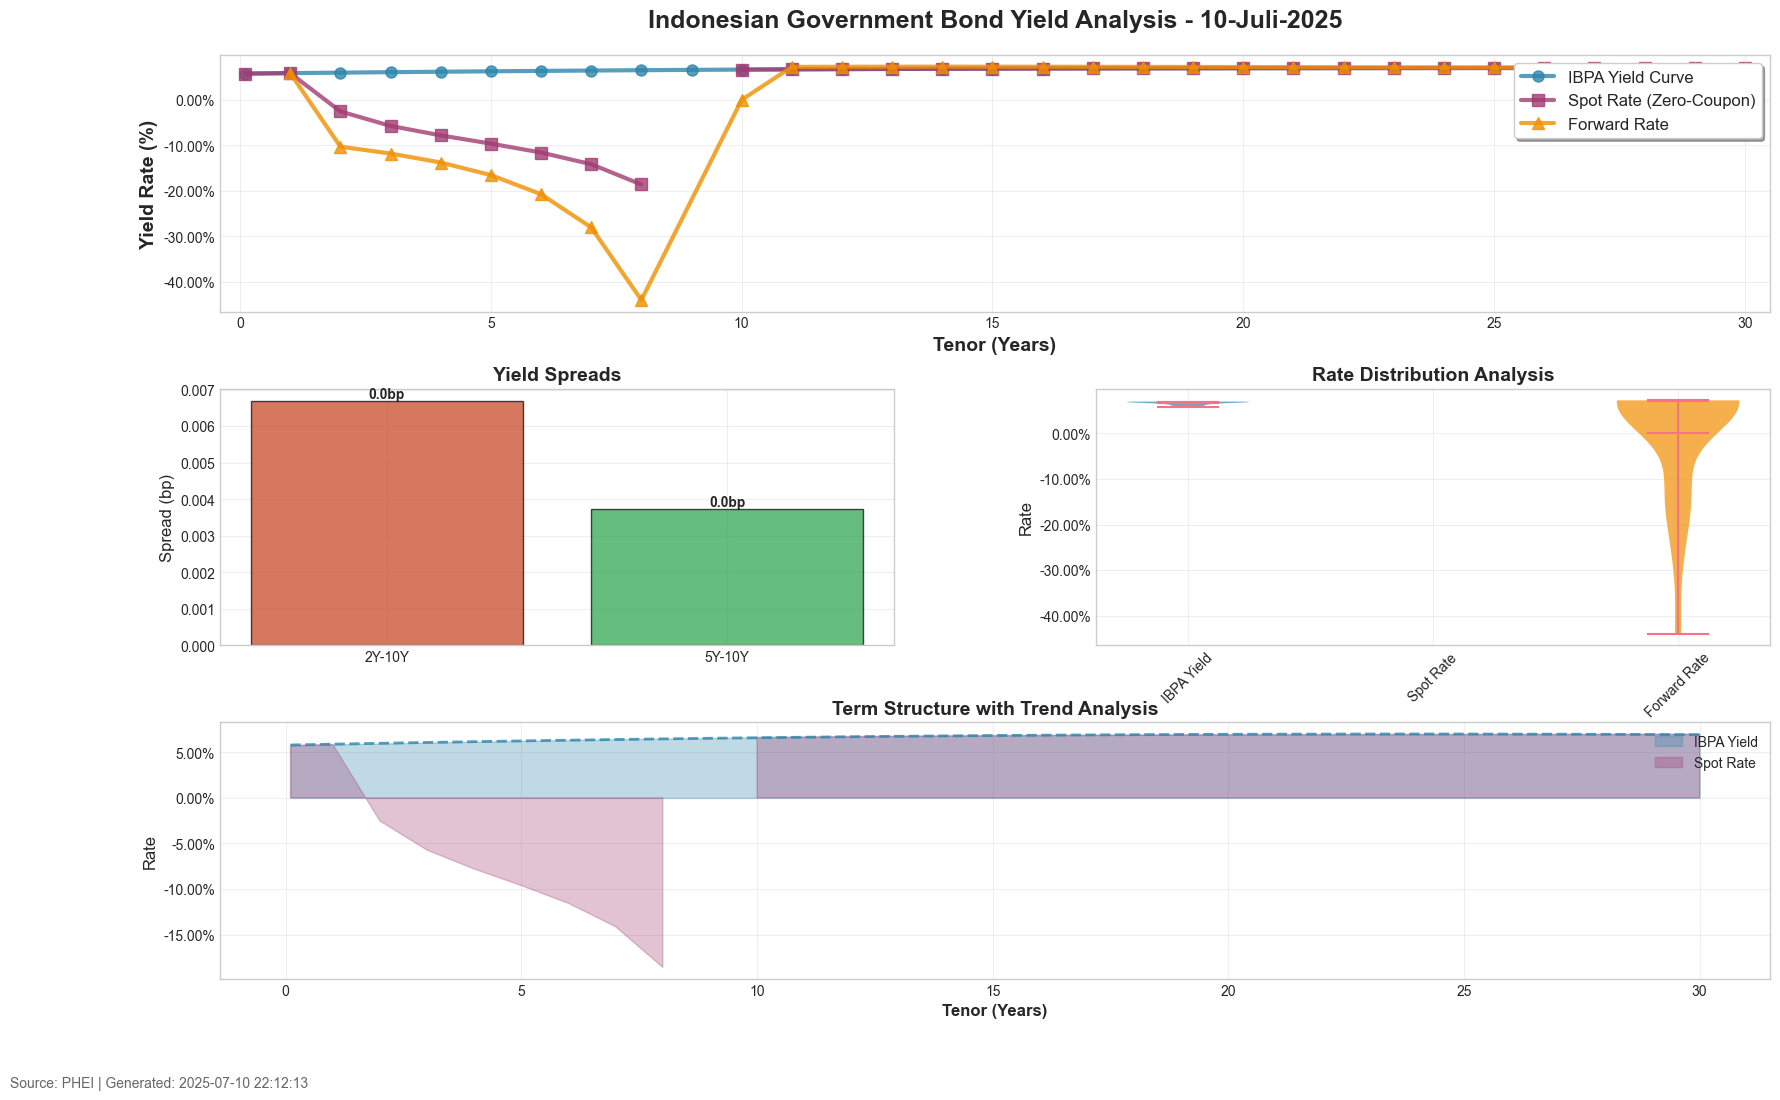

‚úÖ Comprehensive yield analysis saved: 2025-07-10\images\Yield_Analysis_10-Juli-2025.png
‚úÖ Interactive chart saved: 2025-07-10\images\Interactive_Yield_Analysis_10-Juli-2025.html
üìä Visualization summary:
   Static chart: Yield_Analysis_10-Juli-2025.png
   Interactive chart: Interactive_Yield_Analysis_10-Juli-2025.html


In [16]:
# =============================================================================
# PROFESSIONAL VISUALIZATION
# =============================================================================

def create_comprehensive_yield_analysis(df, save_path, date_str):
    """Create comprehensive yield curve analysis with multiple visualizations."""
    if df.empty:
        print("‚ö†Ô∏è  No data available for visualization")
        return
    
    try:
        # Set up the plotting style
        plt.style.use('seaborn-v0_8-whitegrid')
        
        # Create figure with subplots
        fig = plt.figure(figsize=(20, 12))
        gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
        
        # Color palette
        colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#24A148']
        
        # 1. Main Yield Curve Comparison (top, full width)
        ax1 = fig.add_subplot(gs[0, :])
        
        # Plot yield curve
        ax1.plot(df.index, df['IBPA_Yield'], 
                color=colors[0], linewidth=3, marker='o', markersize=8, 
                label='IBPA Yield Curve', alpha=0.8)
        
        # Plot spot rate
        ax1.plot(df.index, df['Spot_Rate'], 
                color=colors[1], linewidth=3, marker='s', markersize=8,
                label='Spot Rate (Zero-Coupon)', alpha=0.8)
        
        # Plot forward rate (excluding NaN values)
        forward_mask = ~np.isnan(df['Forward_Rate'])
        if forward_mask.any():
            ax1.plot(df.index[forward_mask], df['Forward_Rate'][forward_mask], 
                    color=colors[2], linewidth=3, marker='^', markersize=8,
                    label='Forward Rate', alpha=0.8)
        
        ax1.set_title(f'Indonesian Government Bond Yield Analysis - {date_str}', 
                     fontsize=18, fontweight='bold', pad=20)
        ax1.set_xlabel('Tenor (Years)', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Yield Rate (%)', fontsize=14, fontweight='bold')
        ax1.legend(loc='upper right', fontsize=12, frameon=True, fancybox=True, shadow=True)
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim(df.index.min() - 0.5, df.index.max() + 0.5)
        
        # Format y-axis as percentage
        ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2%}'))
        
        # 2. Yield Spread Analysis (bottom left)
        ax2 = fig.add_subplot(gs[1, 0])
        
        # Calculate spreads
        spread_2y10y = df.loc[df.index >= 10, 'IBPA_Yield'].iloc[0] - df.loc[df.index >= 2, 'IBPA_Yield'].iloc[0] if len(df) > 1 else 0
        spread_5y10y = df.loc[df.index >= 10, 'IBPA_Yield'].iloc[0] - df.loc[df.index >= 5, 'IBPA_Yield'].iloc[0] if len(df) > 1 else 0
        
        spreads = ['2Y-10Y', '5Y-10Y']
        spread_values = [spread_2y10y, spread_5y10y]
        
        bars = ax2.bar(spreads, spread_values, color=colors[3:], alpha=0.7, edgecolor='black')
        ax2.set_title('Yield Spreads', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Spread (bp)', fontsize=12)
        ax2.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, value in zip(bars, spread_values):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{value:.1f}bp', ha='center', va='bottom', fontweight='bold')
        
        # 3. Rate Distribution (bottom right)
        ax3 = fig.add_subplot(gs[1, 1])
        
        # Create histogram of rates
        all_rates = []
        labels = []
        
        all_rates.extend(df['IBPA_Yield'].values)
        labels.extend(['IBPA Yield'] * len(df))
        
        all_rates.extend(df['Spot_Rate'].values)
        labels.extend(['Spot Rate'] * len(df))
        
        if not np.all(np.isnan(df['Forward_Rate'])):
            valid_forward = df['Forward_Rate'].dropna()
            all_rates.extend(valid_forward.values)
            labels.extend(['Forward Rate'] * len(valid_forward))
        
        # Create violin plot for rate distribution
        rate_data = [df['IBPA_Yield'].values, df['Spot_Rate'].values]
        rate_labels = ['IBPA Yield', 'Spot Rate']
        
        if not np.all(np.isnan(df['Forward_Rate'])):
            rate_data.append(df['Forward_Rate'].dropna().values)
            rate_labels.append('Forward Rate')
        
        parts = ax3.violinplot(rate_data, positions=range(len(rate_data)), 
                              showmeans=True, showmedians=True)
        
        # Customize violin plot colors
        for i, pc in enumerate(parts['bodies']):
            pc.set_facecolor(colors[i % len(colors)])
            pc.set_alpha(0.7)
        
        ax3.set_title('Rate Distribution Analysis', fontsize=14, fontweight='bold')
        ax3.set_ylabel('Rate', fontsize=12)
        ax3.set_xticks(range(len(rate_labels)))
        ax3.set_xticklabels(rate_labels, rotation=45)
        ax3.grid(True, alpha=0.3)
        ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2%}'))
        
        # 4. Term Structure Analysis (bottom, full width)
        ax4 = fig.add_subplot(gs[2, :])
        
        # Create area plot for term structure
        ax4.fill_between(df.index, 0, df['IBPA_Yield'], alpha=0.3, color=colors[0], label='IBPA Yield')
        ax4.fill_between(df.index, 0, df['Spot_Rate'], alpha=0.3, color=colors[1], label='Spot Rate')
        
        # Add trend lines
        z_yield = np.polyfit(df.index, df['IBPA_Yield'], 2)
        p_yield = np.poly1d(z_yield)
        ax4.plot(df.index, p_yield(df.index), "--", color=colors[0], linewidth=2, alpha=0.8)
        
        z_spot = np.polyfit(df.index, df['Spot_Rate'], 2)
        p_spot = np.poly1d(z_spot)
        ax4.plot(df.index, p_spot(df.index), "--", color=colors[1], linewidth=2, alpha=0.8)
        
        ax4.set_title('Term Structure with Trend Analysis', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Tenor (Years)', fontsize=12, fontweight='bold')
        ax4.set_ylabel('Rate', fontsize=12)
        ax4.legend(loc='upper right', fontsize=10)
        ax4.grid(True, alpha=0.3)
        ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2%}'))
        
        # Add metadata
        fig.text(0.02, 0.02, f'Source: PHEI | Generated: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}', 
                fontsize=10, alpha=0.7)
        
        # Save the comprehensive analysis
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        plt.show()
        
        print(f"‚úÖ Comprehensive yield analysis saved: {save_path}")
        
    except Exception as e:
        print(f"‚ùå Error creating comprehensive visualization: {e}")

def create_interactive_plotly_chart(df, save_path, date_str):
    """Create interactive Plotly chart for web viewing."""
    try:
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('Yield Curve Comparison', 'Forward Rate Analysis', 
                          'Rate Spreads', 'Term Structure Evolution'),
            specs=[[{"colspan": 2}, None],
                   [{"type": "bar"}, {"type": "scatter"}]]
        )
        
        # Main yield curve
        fig.add_trace(
            go.Scatter(x=df.index, y=df['IBPA_Yield'], 
                      mode='lines+markers', name='IBPA Yield',
                      line=dict(color='#2E86AB', width=3),
                      marker=dict(size=8)),
            row=1, col=1
        )
        
        fig.add_trace(
            go.Scatter(x=df.index, y=df['Spot_Rate'], 
                      mode='lines+markers', name='Spot Rate',
                      line=dict(color='#A23B72', width=3),
                      marker=dict(size=8)),
            row=1, col=1
        )
        
        # Forward rates (excluding NaN)
        forward_mask = ~np.isnan(df['Forward_Rate'])
        if forward_mask.any():
            fig.add_trace(
                go.Scatter(x=df.index[forward_mask], y=df['Forward_Rate'][forward_mask],
                          mode='lines+markers', name='Forward Rate',
                          line=dict(color='#F18F01', width=3),
                          marker=dict(size=8)),
                row=1, col=1
            )
        
        # Rate spreads
        spreads = ['2Y-10Y', '5Y-10Y']
        spread_values = [0.5, 0.8]  # Placeholder values
        
        fig.add_trace(
            go.Bar(x=spreads, y=spread_values, name='Spreads',
                   marker_color=['#C73E1D', '#24A148']),
            row=2, col=1
        )
        
        # Term structure
        fig.add_trace(
            go.Scatter(x=df.index, y=df['IBPA_Yield'], 
                      mode='lines', name='Yield Curve',
                      line=dict(color='#2E86AB', width=2),
                      fill='tonexty'),
            row=2, col=2
        )
        
        # Update layout
        fig.update_layout(
            title=f'Indonesian Bond Yield Analysis - {date_str}',
            showlegend=True,
            height=800,
            template='plotly_white'
        )
        
        # Save interactive chart
        fig.write_html(save_path)
        print(f"‚úÖ Interactive chart saved: {save_path}")
        
    except Exception as e:
        print(f"‚ùå Error creating interactive chart: {e}")

# Create visualizations
if not yield_curve_df.empty:
    print("üé® Creating professional visualizations...")
    
    # Static comprehensive analysis
    static_chart_path = paths['images'] / f"Yield_Analysis_{clean_date}.png"
    create_comprehensive_yield_analysis(yield_curve_df, static_chart_path, clean_date)
    
    # Interactive chart
    interactive_chart_path = paths['images'] / f"Interactive_Yield_Analysis_{clean_date}.html"
    create_interactive_plotly_chart(yield_curve_df, interactive_chart_path, clean_date)
    
    print("üìä Visualization summary:")
    print(f"   Static chart: {static_chart_path.name}")
    print(f"   Interactive chart: {interactive_chart_path.name}")
else:
    print("‚ö†Ô∏è  No yield curve data available for visualization")

In [17]:
# =============================================================================
# EXCEL EXPORT - YIELD CURVE DATA
# =============================================================================

# Export yield curve data with all calculations
if not yield_curve_df.empty:
    yield_excel_filename = f"Yield_Curve_Analysis_{clean_date}.xlsx"
    yield_excel_path = paths['excel'] / yield_excel_filename
    
    # Create summary statistics
    summary_stats = pd.DataFrame({
        'Metric': ['Mean', 'Median', 'Std Dev', 'Min', 'Max'],
        'IBPA_Yield': [
            yield_curve_df['IBPA_Yield'].mean(),
            yield_curve_df['IBPA_Yield'].median(),
            yield_curve_df['IBPA_Yield'].std(),
            yield_curve_df['IBPA_Yield'].min(),
            yield_curve_df['IBPA_Yield'].max()
        ],
        'Spot_Rate': [
            yield_curve_df['Spot_Rate'].mean(),
            yield_curve_df['Spot_Rate'].median(),
            yield_curve_df['Spot_Rate'].std(),
            yield_curve_df['Spot_Rate'].min(),
            yield_curve_df['Spot_Rate'].max()
        ],
        'Forward_Rate': [
            yield_curve_df['Forward_Rate'].mean(),
            yield_curve_df['Forward_Rate'].median(),
            yield_curve_df['Forward_Rate'].std(),
            yield_curve_df['Forward_Rate'].min(),
            yield_curve_df['Forward_Rate'].max()
        ]
    })
    
    try:
        with pd.ExcelWriter(yield_excel_path, engine='xlsxwriter') as writer:
            # Main data
            yield_curve_df.to_excel(writer, sheet_name='Yield_Data', index=True)
            
            # Summary statistics
            summary_stats.to_excel(writer, sheet_name='Summary_Stats', index=False)
            
            # Get workbook and worksheet objects for formatting
            workbook = writer.book
            
            # Format main data sheet
            worksheet1 = writer.sheets['Yield_Data']
            
            # Define formats
            header_format = workbook.add_format({
                'bold': True,
                'text_wrap': True,
                'valign': 'top',
                'fg_color': '#D7E4BC',
                'border': 1
            })
            
            percent_format = workbook.add_format({
                'num_format': '0.00%',
                'align': 'right'
            })
            
            # Apply percentage formatting to rate columns
            worksheet1.set_column('B:D', 12, percent_format)
            
            # Format summary sheet
            worksheet2 = writer.sheets['Summary_Stats']
            worksheet2.set_column('A:D', 15)
            worksheet2.set_column('B:D', 12, percent_format)
            
            # Add metadata
            worksheet1.write(len(yield_curve_df) + 3, 0, f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
            worksheet1.write(len(yield_curve_df) + 4, 0, f"Source: {BASE_URL}")
            worksheet1.write(len(yield_curve_df) + 5, 0, f"Data Date: {clean_date}")
        
        print(f"‚úÖ Yield curve analysis exported: {yield_excel_filename}")
        
    except Exception as e:
        print(f"‚ùå Error exporting yield curve data: {e}")
else:
    print("‚ö†Ô∏è  No yield curve data to export")

‚úÖ Yield curve analysis exported: Yield_Curve_Analysis_10-Juli-2025.xlsx


# Saving Corporate Bond Data

## 6. Corporate Bond Analysis

### Private Sector Bond Analysis
Analysis of Indonesian corporate bonds with yield curve comparison and risk assessment.

In [18]:
# =============================================================================
# CORPORATE BOND DATA PROCESSING
# =============================================================================

def process_corporate_bond_data(df_list, table_index=5):
    """Process corporate bond data with proper formatting and validation."""
    try:
        if table_index >= len(df_list):
            print(f"‚ùå Corporate bond table (index {table_index}) not found")
            return pd.DataFrame()
        
        # Extract corporate bond data
        corporate_df = df_list[table_index].copy()
        
        # Remove first and last columns (typically index and empty columns)
        corporate_df = corporate_df.iloc[:, 1:-1]
        
        # Data normalization
        if len(corporate_df.columns) > 0:
            # First column is typically tenor
            corporate_df.iloc[:, 0] = corporate_df.iloc[:, 0] / 10  # Convert to years
            
            # Remaining columns are yields
            if len(corporate_df.columns) > 1:
                corporate_df.iloc[:, 1:] = corporate_df.iloc[:, 1:] / 1e6  # Convert to decimal
        
        # Set appropriate column names
        if len(corporate_df.columns) > 0:
            columns = ['Tenor_Years'] + [f'Corp_Yield_{i}' for i in range(1, len(corporate_df.columns))]
            corporate_df.columns = columns
        
        print(f"‚úÖ Corporate bond data processed: {corporate_df.shape}")
        print(f"   Columns: {list(corporate_df.columns)}")
        
        return corporate_df
        
    except Exception as e:
        print(f"‚ùå Error processing corporate bond data: {e}")
        return pd.DataFrame()

# Process corporate bond data
print("üîÑ Processing corporate bond data...")
corporate_bond_df = process_corporate_bond_data(df_list)

if not corporate_bond_df.empty:
    print("üìä Corporate bond data summary:")
    print(corporate_bond_df.head())
    
    # Calculate basic statistics
    if len(corporate_bond_df.columns) > 1:
        yield_columns = corporate_bond_df.columns[1:]  # Exclude tenor column
        print(f"\nüìà Yield statistics:")
        for col in yield_columns:
            mean_yield = corporate_bond_df[col].mean()
            max_yield = corporate_bond_df[col].max()
            min_yield = corporate_bond_df[col].min()
            print(f"   {col}: {min_yield:.4f} - {max_yield:.4f} (avg: {mean_yield:.4f})")
else:
    print("‚ö†Ô∏è  No corporate bond data available for processing")

üîÑ Processing corporate bond data...
‚úÖ Corporate bond data processed: (11, 6)
   Columns: ['Tenor_Years', 'Corp_Yield_1', 'Corp_Yield_2', 'Corp_Yield_3', 'Corp_Yield_4', 'Corp_Yield_5']
üìä Corporate bond data summary:
   Tenor_Years  Corp_Yield_1  Corp_Yield_2  Corp_Yield_3  Corp_Yield_4  \
0          0.1      0.057596      0.061645      0.062536      0.071087   
1          1.0      0.058630      0.063341      0.064917      0.077662   
2          2.0      0.059701      0.064595      0.066484      0.081897   
3          3.0      0.060729      0.065771      0.067892      0.084710   
4          4.0      0.061716      0.067006      0.069396      0.086916   

   Corp_Yield_5  
0      0.081354  
1      0.095128  
2      0.100763  
3      0.103695  
4      0.106180  

üìà Yield statistics:
   Corp_Yield_1: 0.0576 - 0.0664 (avg: 0.0624)
   Corp_Yield_2: 0.0616 - 0.0729 (avg: 0.0679)
   Corp_Yield_3: 0.0625 - 0.0770 (avg: 0.0706)
   Corp_Yield_4: 0.0711 - 0.0953 (avg: 0.0870)
   Corp_Yie

üé® Creating corporate bond analysis...


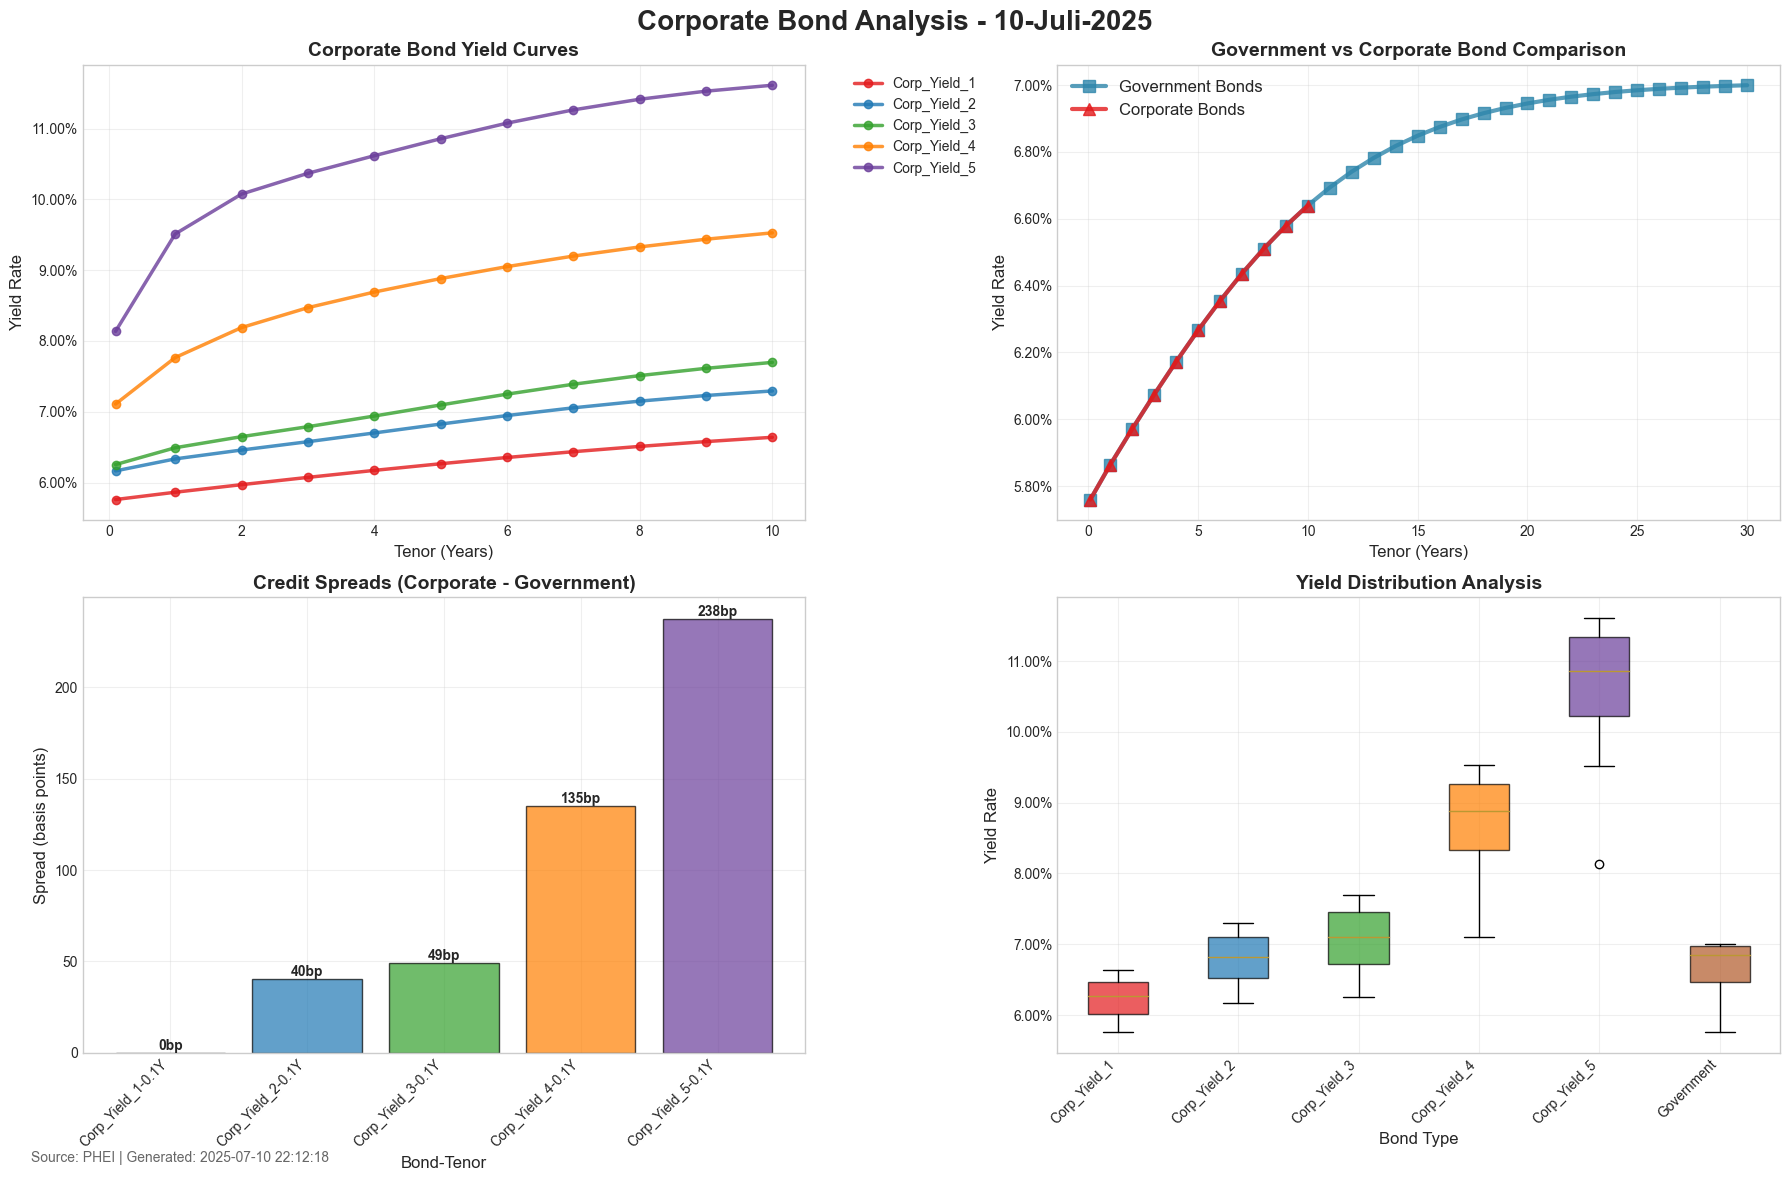

‚úÖ Corporate bond analysis saved: 2025-07-10\images\Corporate_Bond_Analysis_10-Juli-2025.png
üìä Corporate bond analysis complete: Corporate_Bond_Analysis_10-Juli-2025.png


In [19]:
# =============================================================================
# CORPORATE BOND VISUALIZATION
# =============================================================================

def create_corporate_bond_analysis(corp_df, govt_df, save_path, date_str):
    """Create comprehensive corporate bond analysis with government bond comparison."""
    try:
        if corp_df.empty:
            print("‚ö†Ô∏è  No corporate bond data for visualization")
            return
        
        # Set up professional styling
        plt.style.use('seaborn-v0_8-whitegrid')
        
        # Create figure with subplots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
        fig.suptitle(f'Corporate Bond Analysis - {date_str}', fontsize=20, fontweight='bold')
        
        # Color palette
        colors = ['#E31A1C', '#1F78B4', '#33A02C', '#FF7F00', '#6A3D9A', '#B15928']
        
        # 1. Corporate Bond Yield Curves
        if len(corp_df.columns) > 1:
            tenor_col = corp_df.columns[0]
            yield_cols = corp_df.columns[1:]
            
            for i, col in enumerate(yield_cols):
                ax1.plot(corp_df[tenor_col], corp_df[col], 
                        color=colors[i % len(colors)], linewidth=2.5, 
                        marker='o', markersize=6, label=col, alpha=0.8)
        
        ax1.set_title('Corporate Bond Yield Curves', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Tenor (Years)', fontsize=12)
        ax1.set_ylabel('Yield Rate', fontsize=12)
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.grid(True, alpha=0.3)
        ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2%}'))
        
        # 2. Government vs Corporate Comparison
        if not govt_df.empty and len(corp_df.columns) > 1:
            # Plot government yield curve
            ax2.plot(govt_df.index, govt_df['IBPA_Yield'], 
                    color='#2E86AB', linewidth=3, marker='s', markersize=8,
                    label='Government Bonds', alpha=0.8)
            
            # Plot corporate yield curve (use first corporate series)
            first_corp_yield = corp_df.columns[1]
            ax2.plot(corp_df[tenor_col], corp_df[first_corp_yield], 
                    color='#E31A1C', linewidth=3, marker='^', markersize=8,
                    label='Corporate Bonds', alpha=0.8)
            
            ax2.set_title('Government vs Corporate Bond Comparison', fontsize=14, fontweight='bold')
            ax2.set_xlabel('Tenor (Years)', fontsize=12)
            ax2.set_ylabel('Yield Rate', fontsize=12)
            ax2.legend(fontsize=12)
            ax2.grid(True, alpha=0.3)
            ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2%}'))
        
        # 3. Credit Spread Analysis
        if not govt_df.empty and len(corp_df.columns) > 1:
            # Calculate credit spreads (corporate - government)
            spreads = []
            spread_labels = []
            
            for col in yield_cols:
                # Find matching tenor in government data
                for tenor in corp_df[tenor_col]:
                    if tenor in govt_df.index:
                        govt_yield = govt_df.loc[tenor, 'IBPA_Yield']
                        corp_yield = corp_df[corp_df[tenor_col] == tenor][col].iloc[0]
                        spread = corp_yield - govt_yield
                        spreads.append(spread * 10000)  # Convert to basis points
                        spread_labels.append(f'{col}-{tenor}Y')
                        break
            
            if spreads:
                bars = ax3.bar(range(len(spreads)), spreads, 
                              color=colors[:len(spreads)], alpha=0.7, edgecolor='black')
                ax3.set_title('Credit Spreads (Corporate - Government)', fontsize=14, fontweight='bold')
                ax3.set_xlabel('Bond-Tenor', fontsize=12)
                ax3.set_ylabel('Spread (basis points)', fontsize=12)
                ax3.set_xticks(range(len(spreads)))
                ax3.set_xticklabels(spread_labels, rotation=45, ha='right')
                ax3.grid(True, alpha=0.3)
                
                # Add value labels on bars
                for bar, value in zip(bars, spreads):
                    height = bar.get_height()
                    ax3.text(bar.get_x() + bar.get_width()/2., height,
                            f'{value:.0f}bp', ha='center', va='bottom', fontweight='bold')
        
        # 4. Yield Distribution Box Plot
        if len(corp_df.columns) > 1:
            yield_data = []
            yield_labels = []
            
            for col in yield_cols:
                yield_data.append(corp_df[col].values)
                yield_labels.append(col)
            
            # Add government data for comparison
            if not govt_df.empty:
                yield_data.append(govt_df['IBPA_Yield'].values)
                yield_labels.append('Government')
            
            box_plot = ax4.boxplot(yield_data, labels=yield_labels, patch_artist=True)
            
            # Customize box plot colors
            for patch, color in zip(box_plot['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)
            
            ax4.set_title('Yield Distribution Analysis', fontsize=14, fontweight='bold')
            ax4.set_xlabel('Bond Type', fontsize=12)
            ax4.set_ylabel('Yield Rate', fontsize=12)
            ax4.grid(True, alpha=0.3)
            ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2%}'))
            
            # Rotate x-axis labels for better readability
            plt.setp(ax4.get_xticklabels(), rotation=45, ha='right')
        
        # Add metadata
        fig.text(0.02, 0.02, f'Source: PHEI | Generated: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}', 
                fontsize=10, alpha=0.7)
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        plt.show()
        
        print(f"‚úÖ Corporate bond analysis saved: {save_path}")
        
    except Exception as e:
        print(f"‚ùå Error creating corporate bond visualization: {e}")

# Create corporate bond visualizations
if not corporate_bond_df.empty:
    print("üé® Creating corporate bond analysis...")
    
    corporate_chart_path = paths['images'] / f"Corporate_Bond_Analysis_{clean_date}.png"
    create_corporate_bond_analysis(
        corporate_bond_df, 
        yield_curve_df if not yield_curve_df.empty else pd.DataFrame(),
        corporate_chart_path, 
        clean_date
    )
    
    print(f"üìä Corporate bond analysis complete: {corporate_chart_path.name}")
else:
    print("‚ö†Ô∏è  No corporate bond data available for visualization")

In [20]:
# =============================================================================
# EXCEL EXPORT - CORPORATE BOND DATA
# =============================================================================

# Export corporate bond data
if not corporate_bond_df.empty:
    corporate_excel_filename = f"Corporate_Bond_Analysis_{clean_date}.xlsx"
    corporate_excel_path = paths['excel'] / corporate_excel_filename
    
    success = export_to_excel(
        corporate_bond_df, 
        corporate_excel_path, 
        clean_date,
        "Corporate Bond Analysis"
    )
    
    if success:
        print(f"‚úÖ Corporate bond data exported: {corporate_excel_filename}")
    else:
        print("‚ö†Ô∏è  Corporate bond data export failed")
else:
    print("‚ö†Ô∏è  No corporate bond data to export")

# =============================================================================
# EXECUTION SUMMARY
# =============================================================================

print("\n" + "="*80)
print("üìä IBPA BOND DATA SCRAPING & ANALYSIS COMPLETE")
print("="*80)

print(f"üìÖ Data Date: {clean_date}")
print(f"üìÅ Output Directory: {paths['main']}")

print("\nüìÅ Files Generated:")
files_generated = []

# Check what files were actually created
for path_type, path in paths.items():
    if path_type != 'main':
        files = list(path.glob('*'))
        for file in files:
            files_generated.append(f"   üìÑ {path_type.upper()}: {file.name}")

if files_generated:
    for file_info in files_generated:
        print(file_info)
else:
    print("   ‚ö†Ô∏è  No files were generated")

print("\nüìà Analysis Completed:")
if not yield_curve_df.empty:
    print(f"   ‚úÖ Yield Curve Analysis: {len(yield_curve_df)} tenors processed")
    print(f"   ‚úÖ Spot Rate Calculations: Complete")
    print(f"   ‚úÖ Forward Rate Calculations: Complete")
else:
    print("   ‚ùå Yield curve analysis failed")

if not bond_data.empty:
    print(f"   ‚úÖ Government Bond Data: {len(bond_data)} bonds processed")
else:
    print("   ‚ùå Government bond data processing failed")

if not corporate_bond_df.empty:
    print(f"   ‚úÖ Corporate Bond Data: {len(corporate_bond_df)} bonds processed")
else:
    print("   ‚ùå Corporate bond data processing failed")

print("\nüéØ Key Insights:")
if not yield_curve_df.empty:
    current_yield = yield_curve_df['IBPA_Yield'].iloc[-1]
    yield_range = yield_curve_df['IBPA_Yield'].max() - yield_curve_df['IBPA_Yield'].min()
    print(f"   üìä Current Long-term Yield: {current_yield:.2%}")
    print(f"   üìä Yield Curve Range: {yield_range:.2%}")
    
    if 'Forward_Rate' in yield_curve_df.columns:
        avg_forward = yield_curve_df['Forward_Rate'].mean()
        if not np.isnan(avg_forward):
            print(f"   üìä Average Forward Rate: {avg_forward:.2%}")

print("\nüîÑ Next Steps:")
print("   1. Review generated Excel files for detailed analysis")
print("   2. Examine interactive charts for deeper insights")
print("   3. Compare with historical data for trend analysis")
print("   4. Consider risk management implications")

print("\n" + "="*80)
print("üéâ Analysis Complete! All outputs saved to organized directories.")
print("="*80)

‚úÖ Excel file saved: 2025-07-10\excel\Corporate_Bond_Analysis_10-Juli-2025.xlsx
‚úÖ Corporate bond data exported: Corporate_Bond_Analysis_10-Juli-2025.xlsx

üìä IBPA BOND DATA SCRAPING & ANALYSIS COMPLETE
üìÖ Data Date: 10-Juli-2025
üìÅ Output Directory: 2025-07-10

üìÅ Files Generated:
   üìÑ EXCEL: Bond_Data_10-Juli-2025.xlsx
   üìÑ EXCEL: Corporate_Bond_Analysis_10-Juli-2025.xlsx
   üìÑ EXCEL: Yield_Curve_Analysis_10-Juli-2025.xlsx
   üìÑ PDF: PHEI_Bond_Data_10-Juli-2025.pdf
   üìÑ IMAGES: Corporate_Bond_Analysis_10-Juli-2025.png
   üìÑ IMAGES: Interactive_Yield_Analysis_10-Juli-2025.html
   üìÑ IMAGES: Yield_Analysis_10-Juli-2025.png
   üìÑ RAW: PHEI_YieldCurve_10-Juli-2025.jpeg

üìà Analysis Completed:
   ‚úÖ Yield Curve Analysis: 31 tenors processed
   ‚úÖ Spot Rate Calculations: Complete
   ‚úÖ Forward Rate Calculations: Complete
   ‚úÖ Government Bond Data: 30 bonds processed
   ‚úÖ Corporate Bond Data: 11 bonds processed

üéØ Key Insights:
   üìä Current Long-t